
# Diseño de software para cómputo científico

----

## Unidad 6: Integración con lenguajes de alto nivel con bajo nivel.


## Recapitulando

- Escribimos el código Python.
- Pasamos todo a numpy.
- Hicimos profile.
- Paralelisamos (joblib/dask).
- Hicimos profile.
- Usamos Numba.
- Hicimos profile.
- **Si llegamos acá** Cython


## Imports

In [1]:
# vamos a hacer profiling
import timeit
import math

# vamos a plotear
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np

## Numba vs Cython

- Cython es un compilador estático/optimizador tanto para el lenguaje de programación Python como para el extenciones en Cython. 
- Hace que escribir extensiones C para Python sea tan ""fácil"" como el propio Python.
- En lugar de analizar bytecode y generar IR, Cython usa un superconjunto de sintaxis de Python que luego se traduce en código C (Se escribe código C con sintaxis Python).
- A diferencia de usar C, **generalmente** no hay que preocuparse las llamadas de bajo nivel de Python (esto se expande automáticamente a un código C por Cython).
- A diferencia de Numba, todo el código debe estar separado en archivos especiales (`*.pyx`). 
- Cython analiza y traduce dichos archivos a código C y luego lo compila utilizando el compilador C proporcionado.

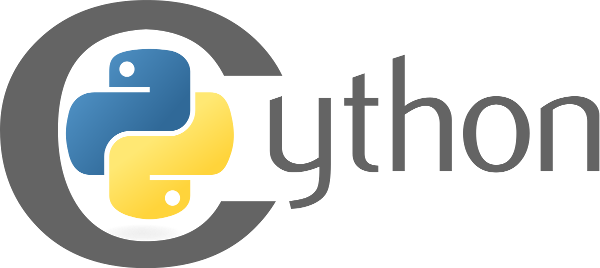

### Por qué preferimos Numba/JIT sobre Cython?

- Curva de aprendizaje (Es otro lenguaje)
- Necesitas *algo* de experiencia en C *+* Python
- El paquete se vuelve un poco complejo.
- Todo código Python es Cython válido

### Por qué preferimos Cython sobre Numba/C/Fortran?

Facil interaccion con librerias C/C++ y integración total con objetos y clases python

## Ejemplo - Mandelbrot Fractal Python Puro

In [2]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

## Ejemplo - Mandelbrot Fractal Python Puro

2.8 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


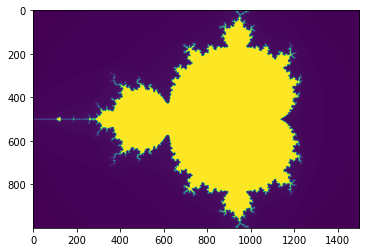

In [3]:
# creamos la imagen
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

# ejecutamos los calculos
normal = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

# mostramos todo
plt.imshow(image, cmap="viridis");

## Ejemplo - Mandelbrot Fractal Cython

In [4]:
#!pip install Cython

In [5]:
%load_ext Cython

In [6]:
%%cython --annotate

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

## Ejemplo - Mandelbrot Fractal Cython

1.87 s ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


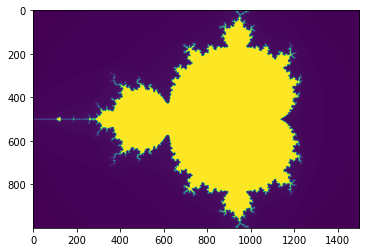

In [7]:
# creamos la imagen
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

# ejecutamos los calculos
normal = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

# mostramos todo
plt.imshow(image, cmap="viridis");

## Cython Hello World 1/2

- Como Cython puede aceptar casi cualquier archivo fuente de Python válido, una de las cosas más difíciles para comenzar es descubrir cómo compilar su extensión.
- Entonces, comencemos con el hola-mundo canónico de Python:

```python 
## helloworld.pyx
print("Hello World")
```

- Pueden ver el código resultante con 
    - `cython -3 helloworld.pyx`,
    - o `cython -3 helloworld.pyx -cplus`

## Cython Hello World 2/2

- Y en  al lado del `pyproject.toml` se implementa un `setup.py` que tiene que tener

```python
from distutils.core import setup
from Cython.Build import cythonize
setup(
    ...
    ext_modules=cythonize("helloworld.pyx"))
```
y en el `pyproject.toml`

```toml
[build-system]
requires = ["setuptools", "wheel", "Cython"]
build-backend = "setuptools.build_meta"
```
- Luego ejecutar `pip install -q build && python -m build`
- Y ya pueden importar `import mult`
- Probamos con `python -c "import helloworld"`

In [8]:
import sys
sys.path.insert(0, "./cython")

import helloworld
helloworld.__file__

ModuleNotFoundError: No module named 'helloworld'

## Cython - Números Primos

In [10]:
%%cython
def primes(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]  
    if nb_primes > 1000:
        nb_primes = 1000
    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
    # Let's return the result in a python list:
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

In [11]:
print(primes(100))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541]


## Cython - Números Primos - Numpy

In [7]:
%%cython
import numpy as np # importar donde vas a compilar

def primes_np(int nb_primes):
    
    # Memoryview on a NumPy array
    narr = np.empty(nb_primes, dtype=np.dtype(int))
    cdef long [:] narr_view = narr
    
    cdef long len_p = 0  # The current number of elements in p.
    cdef long  n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in narr_view[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            narr_view[len_p] = n
            len_p += 1
        n += 1
    return narr

In [13]:
print(primes_np(2000))

[    2     3     5 ... 17383 17387 17389]


## Cython - Números Primos - Profiling


In [8]:
%%cython --annotate
import numpy as np # importar donde vas a compilar

cdef primes_np(unsigned int nb_primes):
    
    # Memoryview on a NumPy array
    narr = np.empty(nb_primes, dtype=np.dtype(int))
    cdef long [:] narr_view = narr
    
    cdef long len_p = 0  # The current number of elements in p.
    cdef long  n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in narr_view[:len_p]:
            if n % i == 0:
                break
        # If no break occurred in the loop, we have a prime.
        else:
            narr_view[len_p] = n
            len_p += 1
        n += 1
    return narr

/home/juanbc/.cache/ipython/cython/_cython_magic_c6e383d238af645ecf7aaae235e9dc9a.c:2187:18: warning: ‘__pyx_f_46_cython_magic_c6e383d238af645ecf7aaae235e9dc9a_primes_np’ defined but not used [-Wunused-function]
 2187 | static PyObject *__pyx_f_46_cython_magic_c6e383d238af645ecf7aaae235e9dc9a_primes_np(unsigned int __pyx_v_nb_primes) {
      |                  ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Y si usamos la librería vector de C++

In [18]:
%%cython --cplus

from libcpp.vector cimport vector

def primes_cpp(unsigned int nb_primes):
    cdef int n, i
    cdef vector[int] p
    p.reserve(nb_primes)  # allocate memory for 'nb_primes' elements.

    n = 2
    while p.size() < nb_primes:  # size() for vectors is similar to len()
        for i in p:
            if n % i == 0:
                break
        else:
            p.push_back(n)  # push_back is similar to append()
        n += 1

    # Vectors are automatically converted to Python
    # lists when converted to Python objects.
    return p

## Benchmarks

In [19]:
%timeit primes(1000)
%timeit primes_np(1000)
%timeit primes_cpp(1000)

2.3 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
113 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.29 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Integrando C puro con Cython

- Supongamos que tenemos ya escrito este super complejo codigo C en un archivo que se llama
  `hello_c.c`.

```C
#include <stdio.h>
void f();

void f() {
    printf("%s", "Hello world from a pure C function!\n");
}
```

Y queremos integrarlo a -Python-

Hay que hacer el wrapper `hello_cwrapper.pyx`.

```cython
cdef extern from "hello_c.c":
    void f()
    
cpdef myf():
    f()
 ```
 
 Despues agregarlo al `setup.py`

## Librería externa desde el notebook

In [20]:
%%cython -I ./cython/

cdef extern from "hello_c.c":
    void f()
    
cpdef myf():
    f()

In [21]:
myf()  ## ESTO IMPRIME SI O SI A LA CONSOLA

## Cosas que quedaron pendientes.

- Structs.
- Enums.
- Classes.
- Memory views.

## Finalizando

- Esto **NO** es más rapido que numpy bien utilizado.
- Copite con numba y el rendimiento es similar.
- En general no es peor que C/C++/FORTRAN.
- Lo mejor es que Python es Válido en Cython.

Y finalmente

**Todo lenguaje que tenga una ABI compatible con C puede interactuar con Cython.**

Osea TODO

## Referencias

- https://rushter.com/blog/numba-cython-python-optimization/
- https://cython.org/
- http://docs.cython.org/en/latest/src/userguide/language_basics.html
- https://telliott99.blogspot.com/2010/12/cython-3-my-own-c-source-file.html
- https://stackoverflow.com/questions/32528560/using-setuptools-to-create-a-cython-package-calling-an-external-c-library